In [1]:
!pip install tensorflow scikit-learn

In [2]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Memuat Data
df = pd.read_csv('/content/heart.csv')
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


# **1. Data Preprocessing**
Bagian ini menangani pembersihan dan persiapan data:
 - Memeriksa nilai yang hilang dalam dataset
 - Mengubah variabel kategorikal menjadi format numerik menggunakan Label Encoding
 - Mempersiapkan data untuk input model machine learning

In [4]:
# Cek missing values
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [5]:
# Label encoding untuk kolom kategorikal
le = LabelEncoder()
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for column in categorical_columns:
    df[column] = le.fit_transform(df[column])
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.2,1,1
914,68,1,0,144,193,1,1,141,0,3.4,1,1
915,57,1,0,130,131,0,1,115,1,1.2,1,1
916,57,0,1,130,236,0,0,174,0,0.0,1,1


# **2. Exploratory Data Analysis (EDA)**
Memvisualisasikan dan menganalisis dataset untuk memahami:
- Distribusi kasus penyakit jantung
- Korelasi antara fitur yang berbeda
- Mengidentifikasi pola dan hubungan dalam data

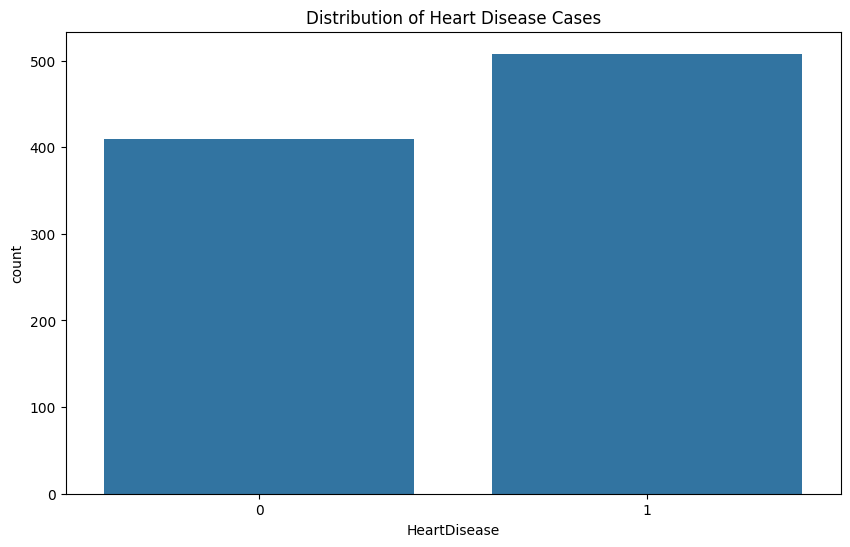

In [6]:
# Visualisasikan distribusi kelas target
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='HeartDisease')
plt.title('Distribution of Heart Disease Cases')
plt.show()

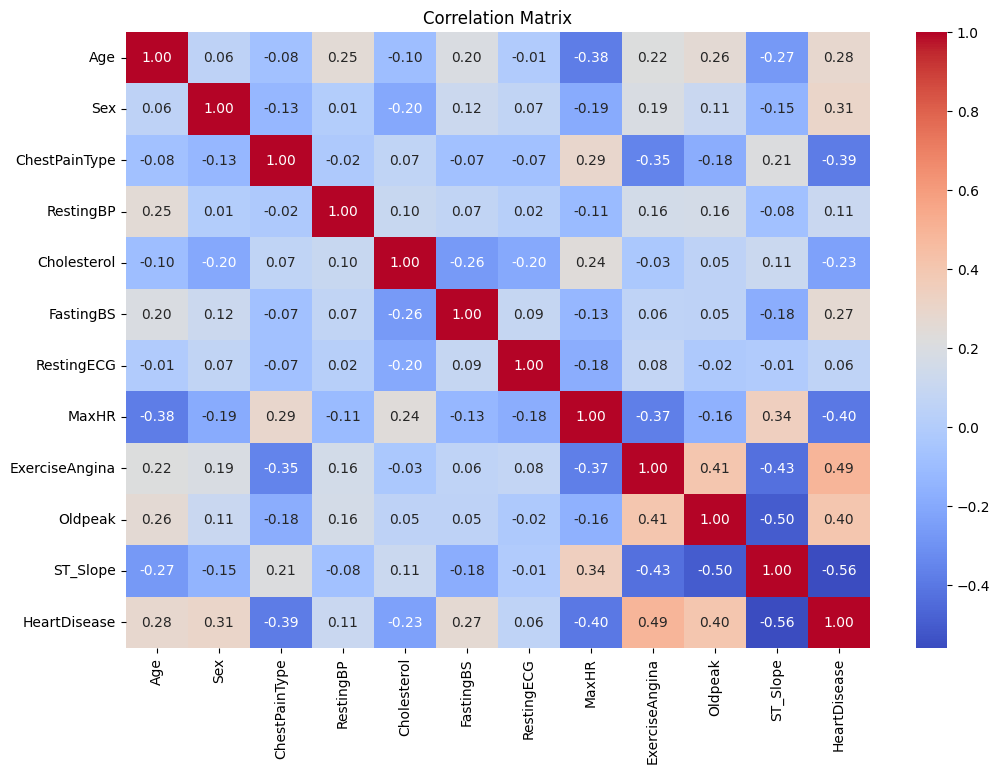

In [7]:
# Correlation matrix / Matriks korelasi
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# **3. Feature Selection**
Memilih fitur yang paling penting untuk model menggunakan SelectKBest:
- Mengidentifikasi 8 fitur teratas yang paling relevan untuk prediksi penyakit jantung
- Mengurangi dimensi sambil mempertahankan kekuatan prediktif
- Meningkatkan efisiensi model dan mengurangi overfitting

In [8]:
# Memisahkan dataset menjadi variabel fitur (X) dan variabel target (y)
# X: mengambil semua kolom kecuali 'HeartDisease' sebagai fitur untuk prediksi
# y: mengambil kolom 'HeartDisease' sebagai target yang akan diprediksi
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

In [9]:
# Menggunakan SelectKBest untuk memilih fitur terbaik
selector = SelectKBest(score_func=f_classif, k=8)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
print("\nSelected Features:")
print(selected_features)


Selected Features:
['Age', 'Sex', 'ChestPainType', 'FastingBS', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']


In [10]:
# Menggunakan hanya fitur yang terpilih
X = X[selected_features]

# **4. Split data dan Scaling**
Mempersiapkan data untuk pelatihan:
- Membagi data menjadi set pelatihan dan pengujian
- Melakukan standardisasi fitur untuk memastikan semua variabel berada pada skala yang sama
- Penting untuk kinerja optimal jaringan saraf


In [11]:
# Membagi data menjadi data latih (80%) dan data uji (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **5. Membuat Model ANN**

In [12]:
# Fungsi untuk membuat arsitektur model Neural Network dengan struktur:
# - Layer input: 64 neuron (ReLU) dengan dropout 30%
# - Hidden layer 1: 32 neuron (ReLU) dengan dropout 20%
# - Hidden layer 2: 16 neuron (ReLU) dengan dropout 10%
# - Layer output: 1 neuron (Sigmoid) untuk klasifikasi biner
# Setiap layer menggunakan dropout untuk mencegah overfitting,
# dengan rate dropout yang semakin mengecil dari awal ke akhir
def create_ann_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    return model

In [13]:
# Inisialisasi model
model = create_ann_model(X_train_scaled.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [15]:
# Early stopping untuk mencegah overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [16]:
# Training model
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.5799 - loss: 0.6802 - val_accuracy: 0.7891 - val_loss: 0.5913
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7464 - loss: 0.5808 - val_accuracy: 0.8095 - val_loss: 0.5140
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8149 - loss: 0.4979 - val_accuracy: 0.8231 - val_loss: 0.4557
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7987 - loss: 0.4847 - val_accuracy: 0.8299 - val_loss: 0.4249
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8358 - loss: 0.4022 - val_accuracy: 0.8435 - val_loss: 0.4136
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8461 - loss: 0.3784 - val_accuracy: 0.8367 - val_loss: 0.4116
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8722 - loss: 0.3503 - val_accuracy: 0.8299 - val_loss: 0.4099
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8397 - loss: 0.3809 - val_accuracy: 0.8299

# **6. Evaluasi Model**

In [17]:
# Plot training history
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

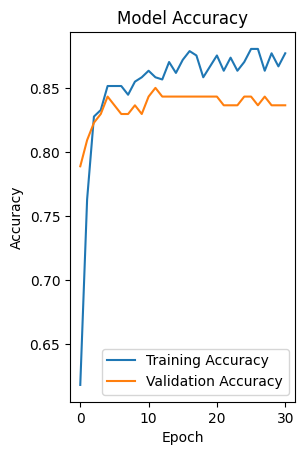

In [18]:
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

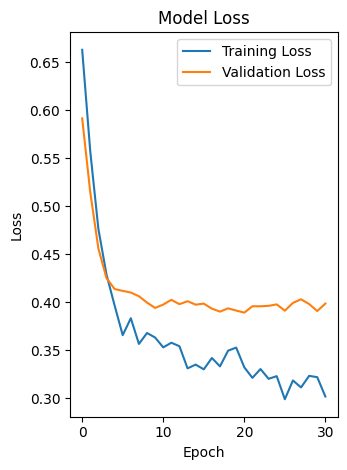

In [19]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# Prediksi
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [21]:
# Metrics
print("\nModel Evaluation:")
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Evaluation:

Accuracy Score: 0.8641304347826086

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        77
           1       0.89      0.87      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



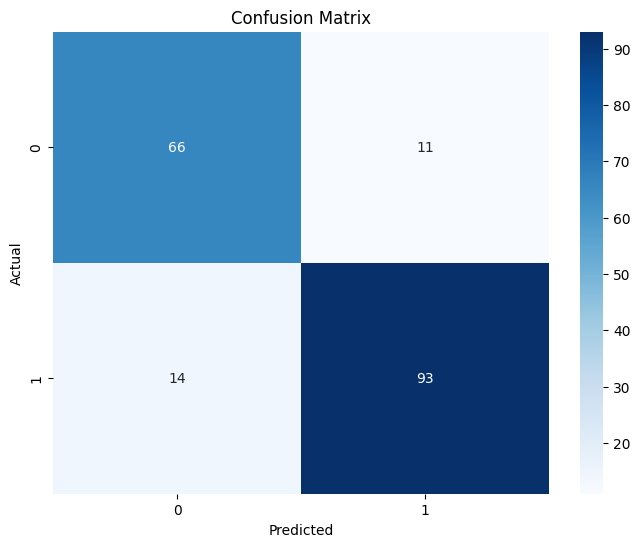

In [22]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [23]:
# Simpan model
model.save('heart_disease_model.h5')

In [24]:
# Simpan scaler
import pickle
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)


In [25]:
# Simpan selected features
with open('selected_features.pkl', 'wb') as file:
    pickle.dump(selected_features, file)

print("\nModel, scaler, dan selected features telah disimpan!")


Model, scaler, dan selected features telah disimpan!
